<h1><center>Andrey Varkentin. Risk management with Python.</center></h1>

In this tutorial we are going to learn some basic risk management instruments, that could be used not only in trading, but also in daily operations of every organisation, which strive to manage its own risks. However, now it is broadly used in financial organisations due to specifics of risks, these organisations are facing.

This tutorial is devoted to VaR and Monte-Carlo simulation and is organized as follows: first, we will introduce theoretical foundations of VaR, then apply basic VaR and Monte-Carlo simulation on Tesla equity prices, finally, look at Bocconi University Student Investment Club example realization of 4 types of VaR.

### Theory

The Value-at-risk (VaR) has been used for decades to assess market risk. In a nutshell, the VaR is a statistical technique used to measure the level of risk of a portfolio given a certain confidence interval and within a fixed timeframe.[[1]](https://medium.com/@Francesco_AI/big-data-and-risk-management-in-financial-markets-part-i-eed4e245f3db)

The VaR can be computed through:

- Historical method - we organise histrical returns in descending order and choose a threshold to define possible losses;
- Delta-Normal method - first step to modelling: we evaluate mean and standard deviation and model the distribution of returns, after that taking the required threshold;
- Monte Carlo simulation - we model returns trajectories, and then run a multitude of simulated trials, which result in distribution of returns.

We will try to implement them in our first part of Tesla equity analysis.

Of course, this is not the complete list of methods. In BSIC approach there are 4 methods of VaR as follows [[2]](http://www.bsic.it/wp-content/uploads/2017/03/VaR-with-Python.pdf):
- Parametric VaR -to build it, the only variables needed are the mean and the standard deviation of a portfolio/security. The problem is that it works under two restrictive assumptions, namely normal distribution and independence of returns. This leads to myopically  equating  all  returns  in  terms  of  importance,  overlooking  big  shocks  that  should  be  carried  over  and should be given more power to impact the actual VaR.
- EWMA (Exponentially weighted moving average) tries to solve the problem of slow reaction to new information and the equal importance of returns. Using a decay factor the EWMA formula is able to weight different information as it comes in, giving more importance to recent returns and less importance to data far in the past by slowly decaying their contribution to the VaR. Through this, the measure limits the ‘echo effect’, occurring when a large shock of the past becomes too old to be considered and leaves the estimation, causing a big change in the VaR which is not due to a change in the markets.
- Historical Simulation(HS) VaR is instead efficient when the risk manager cannot, or doesn’t intend to, make assumptions  on  the  underlying  distribution  of  returns  as  it  is  calculated  by  the  simple  picking  of  the  chosen percentile loss in a given period of time. This method is even simpler than the parametric one and that is precisely its weakness. 
- Filtered Historical Simulation VaR can be described as being a mixture of the historical simulation and EWMA methods. Returns are first standardized, with volatility estimation weighted as in EWMA VaR, before a historical percentile is applied to the standardized return as in the historical model. From the graphs it is easy to spot that this model looks very much like EWMA, as returns are standardised and weighted by the same decay factor. The main difference lies in the fact that this model is generally more conservative because it looks at the worst past losses and adjust its VaR value according to it.

We will look at them in our second part of Tesla equity analysis.



Let's go deep into formal definition of VaR. More information about this, portfolio optimisation technics and etc. can be found [here [3]](http://www.quantatrisk.com/2013/03/08/var-expected-shortfall-black-swan/).

More formally, given a daily (or, weekly, monthly, etc.) distribution of returns (of, for example, a single stock, a portfolio of assets, etc.), we are interested in finding the value of VaRα of, say, α=0.05 (five percent) which would say to as that there is 5% of chances that the value of VaR 0.05 would be exceeded in trading on the next day. This value is located in the left tail of the distribution and, by convention, it is given as positive number. Therefore, we define VaRα as:
$$P[X\leq VaR\alpha]=1-\alpha$$

Okay then, having VaRα calculated we know how far the loss could reach at the 1−α confidence level. The next super important question in risk management every risk manager should ask or at least be interested in reporting is: if VaRα event occurs on the next day, what is the expected loss we might expect to suffer (say, in dollars)? VaRα is the threshold. Now we are interested in the expected value of loss given the exceedance. It is the definition of expected shortfall and is based on the concept of conditional probability as follows:

$$E[X  |  X \gt VaR\alpha] = ES$$ . 

In general, if our daily distribution of returns can be described by a function f(x) which would represent a power density function (pdf), then:

$$ES = 1 / \alpha \int_{-\infty}^{VaR\alpha}xf(x)dx.$$ 

VaRα and ES can be, in fact, calculated by the method is based on the empirical distribution, i.e. using data as given:

$$VaR\alpha=h^{VaR}_{i}$$  for $$ \sum _{i=1}^{M-1}H_{i}(h_{i+1}-h_{i}) \leq \alpha ,$$

where H represents the normalized histogram of returns (i.e., its integral is equal 1) and M is the number of histograms bins. Similarly for ES, we get:

$$ES = \sum_{i=1}^{h^{VaR}_{i}} h_{i}H_{i}(h_{i+1}-h_{i}).$$ 

### Practice. Tesla equities from 2010.

Let's try to implement all theoretical constructions on history of Tesla equity prices from 29/06/2010

In [6]:
# install package for downloading equity prices
# !pip install pandas-datareader

In [2]:
# necessary packages
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas_datareader import data
 
#download tesla price data into DataFrame
tesla = data.DataReader('TSLA', 'yahoo',start='29/06/2010')
 
#calculate the compound annual growth rate (CAGR) which 
#will give us our mean return input (mu) 
days = (tesla.index[-1] - tesla.index[0]).days
cagr = ((((tesla['Adj Close'][-1]) / tesla['Adj Close'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr
 
#create a series of percentage returns and calculate 
#the annual volatility of returns
tesla['Returns'] = tesla['Adj Close'].pct_change()
vol = tesla['Returns'].std()*math.sqrt(252)#252 - number of trading days
print ("Annual Volatility =",str(round(vol,4)*100)+"%")

CAGR = 37.82%
Annual Volatility = 51.6%


Uhm, high growth rates and volatility, situation typical for startups.

Let's plot charts for Tesla with Seaborn and Bokeh to see the whole dynamics.

In [4]:
tesla.head()

,High,Low,Open,Close,Volume,Adj Close,Returns
Date,,,,,,,
2010-06-29,25.00,17.540001,19.000000,23.889999,18766300,23.889999,NaN
2010-06-30,30.42,23.299999,25.790001,23.830000,17187100,23.830000,-0.002511
2010-07-01,25.92,20.270000,25.000000,21.959999,8218800,21.959999,-0.078473
2010-07-02,23.10,18.709999,23.000000,19.200001,5139800,19.200001,-0.125683
2010-07-06,20.00,15.830000,20.000000,16.110001,6866900,16.110001,-0.160938


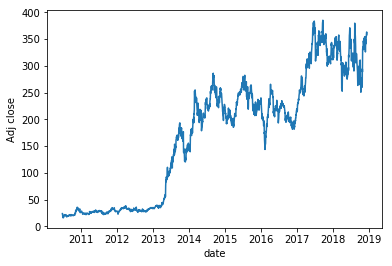

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(data = tesla['Adj Close'])
ax.set(xlabel='date', ylabel='Adj close')
plt.show()

For Bokeh candlestick visualization we need column date

In [21]:
tesla2 = tesla.reset_index()

In [23]:
from math import pi
import pandas as pd
from bokeh.plotting import figure, show, output_file


tesla2["Date"] = pd.to_datetime(tesla2["Date"])

mids = (tesla2.Open + tesla2.Close)/2
spans = abs(tesla2.Close-tesla2.Open)

inc = tesla2.Close > tesla2.Open
dec = tesla2.Open > tesla2.Close
w = 12*60*60*1000 # half day in ms

output_file("candlestick.html", title="candlestick.py example")

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, toolbar_location="left")

p.segment(tesla2.Date, tesla2.High, tesla2.Date, tesla2.Low, color="black")
p.rect(tesla2.Date[inc], mids[inc], w, spans[inc], fill_color="#D5E1DD", line_color="black")
p.rect(tesla2.Date[dec], mids[dec], w, spans[dec], fill_color="#F2583E", line_color="black")

p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

show(p)  # open a browser

We see that since 2013 price of Tesla equities increased in 12 times and also there are lots of peaks and cavities. We also can divide all historical prices in 3 periods according to price levels: 2010-2013, 2014 - 2016, 2017-2018. For more thorough analisys it is better to calculate VaR separately for each period but for our tutorial we'll ignore this fact.

Let's do 1 circle of our modeling Tesla returns

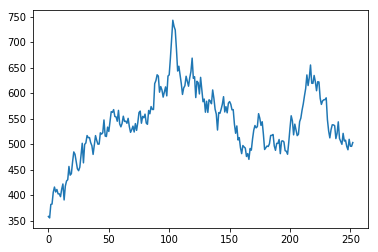

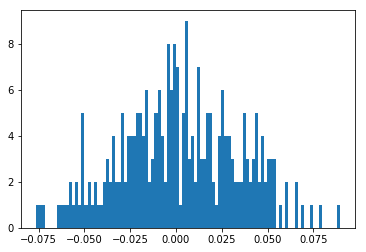

In [19]:
S = tesla['Adj Close'][-1] #starting stock price (i.e. last available real stock price)
T = 252 #Number of trading days
mu = mu #Return
vol = vol #Volatility
 
#create list of daily returns using random normal distribution
daily_returns=np.random.normal((mu/T),vol/math.sqrt(T),T)+1
 
#set starting price and create price series generated by above random daily returns
price_list = [S]
 
for x in daily_returns:
    price_list.append(price_list[-1]*x)

#Generate Plots - price series and histogram of daily returns

plt.plot(price_list)
plt.show()
plt.hist(daily_returns-1, 100) #Note that we run the line plot and histogram separately, not simultaneously.
plt.show()

Histogram reminds normal distribution, though there are some overshoots. Let's repeat it for 1000 times, this is what is done in Monte-Carlo simulation

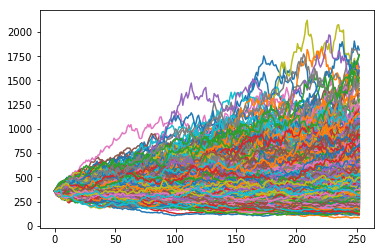

In [25]:
result = []
#choose number of runs to simulate - I have chosen 1000
for i in range(1000):
    #create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/T,vol/math.sqrt(T),T)+1
    
    #set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)
 
    #plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    #append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])

#show the plot of multiple price series created above
plt.show()

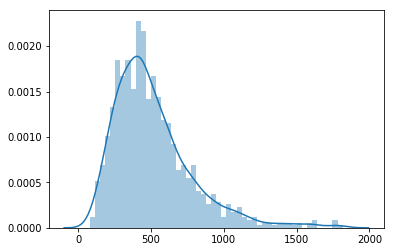

In [28]:
sns.distplot(result,bins=50)


This distribution is not normal, more similar to lognormal, with some overshoots near 1750

In [30]:
#use numpy mean function to calculate the mean of the result
print(round(np.mean(result),2), "$")
print("5% quantile =",np.percentile(result,5))
print("95% quantile =",np.percentile(result,95))

514.96 $
5% quantile = 191.91991907795355
95% quantile = 1051.4964531673588


So we have found that we can expect Tesla equity value of \$514.96. Moreover, there is a 5% chance that our stock price will end up below around \$191.92 and a 5% chance it will finish above $1051.50.

Thus, we can ask ourselves, whether we are ready to risk a 5% chance of ending up with a stock worth less than \$191.92, in order to chase an expected return of around 38%, giving us an expected stock price of around \$514.96?

Let's check the realisation of 4 types of VaR. First, compare absolute VaR values

In [79]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import math

def VaR(Returns, Formula = 'Parametric Normal', Confidence_Interval = 0.95 , Period_Interval = None ,
        EWMA_Discount_Factor = 0.94, Series = False ,removeNa = True):
    
    '''
    This funcction can caluclate both single value VaR and series of VaR values through time.
    Supported formulas as Parametric Normal, Parametric EWMA, Historical Simulation and Filtered Historical Simulation
    
    '''
    
    
    # Removes the NAs from the series
    if removeNa==True: Returns = Returns[pd.notnull(Returns)]
    
    # Data need to be returns already, then here the interval for the sampling is set for No input
    if (Series == True and Period_Interval == None):
        Period_Interval = 100
    elif Period_Interval == None: 
        Period_Interval = len(Returns)
    
    #==========================================================================
    #==========================================================================
    #==========================================================================
    
    #===============================
    #     Parametric Normal VaR 
    #===============================
    if Formula == 'Parametric Normal':
        
        if Series == False: 
            Data = Returns[-Period_Interval:]
            stdev = np.std(Data)
            Value_at_Risk = stdev*norm.ppf(Confidence_Interval)
        if Series == True:
            Value_at_Risk = pd.Series(index=Returns.index, name = 'ParVaR')
            for i in range(0,len(Returns)-Period_Interval):
                if i == 0: Data = Returns[-(Period_Interval):]
                else: Data = Returns[-(Period_Interval+i):-i]
                stdev = np.std(Data)
                Value_at_Risk[-i-1] = stdev*norm.ppf(Confidence_Interval)
    
    #============================
    # EWMA Parametric VaR 
    #============================
    if Formula == 'Parametric EWMA':
    
        ## Defining exponentially smoothed weights components ##
        Degree_of_Freedom = np.empty([Period_Interval,])
        Weights = np.empty([Period_Interval,])
        Degree_of_Freedom[0]=1.0
        Degree_of_Freedom[1]=EWMA_Discount_Factor
        Range = range(Period_Interval)
        for i in range(2,Period_Interval):
            Degree_of_Freedom[i]=Degree_of_Freedom[1]**Range[i]
        for i in range(Period_Interval):
            Weights[i]=Degree_of_Freedom[i]/sum(Degree_of_Freedom)
        
        if Series == False:
            sqrdData = (Returns[-Period_Interval:])**2 ## Squaring returns for the formula
            EWMAstdev=math.sqrt(sum(Weights*sqrdData))
            Value_at_Risk = EWMAstdev*norm.ppf(Confidence_Interval)
        if Series == True:
            Value_at_Risk = pd.Series(index=Returns.index, name = 'EWMAVaR')
            sqrdReturns = Returns**2 ## For efficiency here we square returns first so the loop does not do it repeadetly
            ## This loop repeats the VaR calculation iterated for every xxx period interval
            for i in range(0,len(Returns)-Period_Interval):
                ## this is needed as, supposing x is a number, referencing a pd series as a[x,0] is a mistake. correct is a[x:]
                if i == 0: sqrdData = sqrdReturns[-(Period_Interval):]
                else: sqrdData = sqrdReturns[-(Period_Interval+i):-i]
        
                EWMAstdev=math.sqrt(sum(Weights*sqrdData))
                ## unfortunately pd series work differently for singular entries. So if a[x:] gets up to the last number
                ## a[] does not work. So a[-1] will get the equivalent to the last of a[x:-1] 
                Value_at_Risk[-i-1] = EWMAstdev*norm.ppf(Confidence_Interval)
    
    
    #============================
    #    Historical Simulation 
    #============================
    if Formula == 'Historical Simulation':
        
        if Series == False:
            Data = Returns[-Period_Interval:]
            Value_at_Risk = -np.percentile(Data,1-Confidence_Interval)
        if Series == True:
            Value_at_Risk = pd.Series(index=Returns.index, name = 'HSVaR')
            for i in range(0,len(Returns)-Period_Interval):
                if i == 0: Data = Returns[-(Period_Interval):]
                else: Data = Returns[-(Period_Interval+i):-i]
                Value_at_Risk[-i-1] = -np.percentile(Data,1-Confidence_Interval)
        
    #==================================== 
    #   Filtered Historical Simulation 
    #====================================
    if Formula == 'Filtered Historical Simulation': 
        
        # Defining exponentially smoothed weights components 
        Degree_of_Freedom = np.empty([Period_Interval,])
        Weights = np.empty([Period_Interval,])
        Degree_of_Freedom[0]=1.0
        Degree_of_Freedom[1]=EWMA_Discount_Factor
        Range = range(Period_Interval)
        for i in range(2,Period_Interval):
            Degree_of_Freedom[i]=Degree_of_Freedom[1]**Range[i]
        for i in range(Period_Interval):
            Weights[i]=Degree_of_Freedom[i]/sum(Degree_of_Freedom)
    
        
        Value_at_Risk = pd.Series(index=Returns.index, name = 'FHSVaR')
        EWMAstdev = np.empty([len(Returns)-Period_Interval,])
        stndrData = pd.Series(index=Returns.index)
        
        # For efficiency here we square returns first so the loop does not do it repeadetly 
        sqrdReturns = Returns**2
        
        # Computations here happen in different times, because we first need all the EWMAstdev
        # First get the stdev according to the EWMA
        for i in range(0,len(Returns)-Period_Interval):
            if i == 0: sqrdData = sqrdReturns[-(Period_Interval):]
            else: sqrdData = sqrdReturns[-(Period_Interval+i):-i]
                
            EWMAstdev[-i-1]=math.sqrt(sum(Weights*sqrdData))
        
        # Now get the Standardized data by dividing for the EWMAstdev.
        # Length is here -1 because we standardize by the EWMAstdev of the PREVIOUS period.
        # Hence also EWMAstdev is [-i-2] instead of [-i-1].
        for i in range(0,len(Returns)-Period_Interval-1):
            stndrData[-i-1]=Returns[-i-1]/EWMAstdev[-i-2]
        stndrData = stndrData[pd.notnull(stndrData)]
        #Finally get the percentile and unfilter back the data
        for i in range(0,len(stndrData)-Period_Interval):
            if i == 0: stndrData2 = stndrData[-(Period_Interval):]
            else: stndrData2 = stndrData[-(Period_Interval+i):-i]   
            
            stndrData_pct=np.percentile(stndrData2,1-Confidence_Interval)
        # Unfilter back with the CURRENT stdev
            Value_at_Risk[-i-1]=-(stndrData_pct*EWMAstdev[-i-1])
        
        
        # For FHS the single take of VaR does not work because we need to standardize for the preceeding stdev
        # hence it is always necessary to calculate the whole series and take the last value
        if Series == True:
            Value_at_Risk = Value_at_Risk
        if Series == False:
            Value_at_Risk = Value_at_Risk[-1]
        
             

    return(Value_at_Risk)

def VaR_Compare(Returns, Confidence_Interval = 0.95 , Period_Interval = 100 ,EWMA_Discount_Factor = 0.94):
    
    'This function calculates different VaR series and plots it in the same graph'
    
    # Use for each VaR call the same values, here they are set
    Ret=Returns
    CI = Confidence_Interval
    PI = Period_Interval
    EWMAdf = EWMA_Discount_Factor

    # Call the single VaR series
    VaRPN=VaR(Ret, Formula = 'Parametric Normal', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)
    VaREWMA=VaR(Ret, Formula = 'Parametric EWMA', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)
    VaRHS=VaR(Ret, Formula = 'Historical Simulation', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)
    VaRFHS=VaR(Ret, Formula = 'Filtered Historical Simulation', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)

    # Concat the different VaR series in the same dataframe and plot it
    AllVaR = pd.concat([VaRPN,VaREWMA,VaRHS,VaRFHS], axis = 1)#.reset_index()
#     print(AllVaR.columns)
    from matplotlib import pyplot as plt
    plt.figure(figsize=(8,5))
    sns.lineplot(data = AllVaR, hue = AllVaR.columns)
    plt.legend()
    plt.show()
#     AllVaR.plot(lw=1)
    
    return(AllVaR.columns)

In [83]:
for i in ['Parametric Normal', 'Parametric EWMA', 'Historical Simulation', 'Filtered Historical Simulation']:
    print(i, np.round(VaR(tesla['Returns'], Formula = i, Series=False, removeNa=True),4))

Parametric Normal 0.0535
Parametric EWMA 0.1056
Historical Simulation 0.1603
Filtered Historical Simulation nan


FHS doesn't work with Series = False, so let's look for the whole history and take the mean value.

In [86]:
VaR(tesla['Returns'], Formula = 'Filtered Historical Simulation', Series=True, removeNa=True).mean()

0.10037123974171261

Numbers differ significantly.
What about values in dynamic?

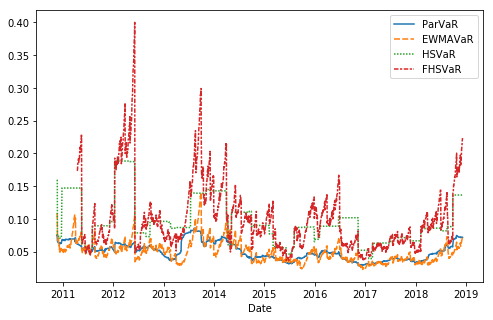

Index(['ParVaR', 'EWMAVaR', 'HSVaR', 'FHSVaR'], dtype='object')

In [80]:
VaR_Compare(tesla['Returns']) #ParVaR EWMAVaR HSVaR FHSVaR

FHS shows the biggest volatility, while conservative ParVaR is most smooth. What to choose is up to you and environment, in which you have to take a decision.

### Conclusion

In this tutorial we have covered some basic instruments of risk management: several application of VaR and Monte-Carlo simulation. One should remember that each of them has its own pros and cons, so use them wisely.

Moreover, there are lots of other methods and technics and even other types of VaR, that are not covered here. For example, there are some extensions called coherent risk measures alternatives. The conditional VaR (CVaR) or expected shortfall, computes the expected return of the portfolio in the worst scenarios for a certain probability level. The entropic VaR (EVaR) instead represents the upper bound for both VaR and CVaR, and its dual representation is related to the concept of relative entropy.

Thus, I hope that this tutorial has helped you to get acquainted with some foundations and got hooked you with this topic.